- [Data Loader](https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2)
- [Explaination to code model](https://youtu.be/k4jY9L8H89U)
- [inferring-shape-via-flatten-operator](https://discuss.pytorch.org/t/inferring-shape-via-flatten-operator/138)
- [OSError: image file is truncated (0 bytes not processed)](https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images)

Based on
- [Article](https://heartbeat.fritz.ai/introduction-to-pytorch-for-deep-learning-5b437cea90ac)
- [Pytorch Official](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

Other Examples referred for generalization
- [Example 1](https://github.com/vatsalsaglani/ApparelClassifier/blob/master/train.py)
- [Example 2](https://gist.github.com/gagejustins/76ab1f37b83684032566b276fe3a5289#file-simplecnn-py)

```
The formula for output neuron:
Output = ((I-K+2P)/S + 1), where
I - a size of input neuron,
K - kernel size,
P - padding,
S - stride
```

[Basic Pytorch Playlist  16, 17, 18](https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Added due to
#OSError: image file is truncated (0 bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
transformations = transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [5]:
def imshow(img):
    # Needed to plot gride images easily
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# Class to index mapping
class_to_idx = None
# Names of classes
classes = None

def load_dataset(path, batch_size, num_workers=0, shuffle = True):
    global class_to_idx, classes
    data_path = path
    dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transformations
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = True
    )

    class_to_idx = dataset.class_to_idx
    classes = list(class_to_idx)
    return loader

In [7]:
class Model(nn.Module):
    def __init__(self, input_shape=None):
        super(Model, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.flat_fts = self.get_flat_fts(input_shape, self.cnn_layers)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(self.flat_fts, 100),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(100,4),
            nn.LogSoftmax())

    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        fts = self.cnn_layers(x)
        flat_fts = fts.view(-1, self.flat_fts)
        out = self.linear_layers(flat_fts)
        return out

In [8]:
n_batches = 32
n_epochs = 25
n_batch_test = 8
loader = load_dataset(path='Data/Skin/train', batch_size=n_batches, num_workers=2)
data_iter = iter(loader)
image, label = next(data_iter)
print('(batch_size, channel, H, W) =', tuple(image.shape))

(batch_size, channel, H, W) = (32, 3, 224, 224)


In [9]:
# defining the model
model = Model(tuple(image.shape)[1:])
# # defining the loss function
# ##criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
# # defining the optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# ##optimizer = Adam(model.parameters(), lr=0.000075)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

Model(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=44944, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=4, bias=True)
    (4): LogSoftmax(dim=None)
  )
)


In [10]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    print('\nEpoch ', epoch+1, '\n')
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(loader, start=0):

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        #print(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('Train Epoch: {} [{:>5}/{:<5} ({:.0f}%)]\tLoss: {:.3f}  '.format(
                epoch+1, batch_idx * len(inputs), len(loader.dataset),
                100. * batch_idx / len(loader), loss.data), end=' ')
            print('Running Loss: {:.3f}'.format(running_loss / 10))
            running_loss = 0.0

print('Finished Training')


Epoch  1 



/home/sam/anaconda3/envs/generator/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [  288/1844  (16%)]	Loss: 1.277   Running Loss: 1.334
Train Epoch: 1 [  608/1844  (33%)]	Loss: 1.141   Running Loss: 1.262
Train Epoch: 1 [  928/1844  (50%)]	Loss: 1.320   Running Loss: 1.226
Train Epoch: 1 [ 1248/1844  (67%)]	Loss: 1.317   Running Loss: 1.164
Train Epoch: 1 [ 1568/1844  (84%)]	Loss: 1.157   Running Loss: 1.149

Epoch  2 

Train Epoch: 2 [  288/1844  (16%)]	Loss: 1.177   Running Loss: 1.124
Train Epoch: 2 [  608/1844  (33%)]	Loss: 1.177   Running Loss: 1.127
Train Epoch: 2 [  928/1844  (50%)]	Loss: 1.089   Running Loss: 1.074
Train Epoch: 2 [ 1248/1844  (67%)]	Loss: 1.095   Running Loss: 1.057
Train Epoch: 2 [ 1568/1844  (84%)]	Loss: 1.243   Running Loss: 1.076

Epoch  3 

Train Epoch: 3 [  288/1844  (16%)]	Loss: 1.241   Running Loss: 0.990
Train Epoch: 3 [  608/1844  (33%)]	Loss: 0.880   Running Loss: 0.969
Train Epoch: 3 [  928/1844  (50%)]	Loss: 0.930   Running Loss: 1.030
Train Epoch: 3 [ 1248/1844  (67%)]	Loss: 1.151   Running Loss: 0.905
Train Epoc

Train Epoch: 23 [ 1568/1844  (84%)]	Loss: 0.912   Running Loss: 0.655

Epoch  24 

Train Epoch: 24 [  288/1844  (16%)]	Loss: 0.673   Running Loss: 0.592
Train Epoch: 24 [  608/1844  (33%)]	Loss: 0.484   Running Loss: 0.581
Train Epoch: 24 [  928/1844  (50%)]	Loss: 0.507   Running Loss: 0.635
Train Epoch: 24 [ 1248/1844  (67%)]	Loss: 0.701   Running Loss: 0.576
Train Epoch: 24 [ 1568/1844  (84%)]	Loss: 0.413   Running Loss: 0.594

Epoch  25 

Train Epoch: 25 [  288/1844  (16%)]	Loss: 0.439   Running Loss: 0.546
Train Epoch: 25 [  608/1844  (33%)]	Loss: 0.603   Running Loss: 0.567
Train Epoch: 25 [  928/1844  (50%)]	Loss: 0.632   Running Loss: 0.581
Train Epoch: 25 [ 1248/1844  (67%)]	Loss: 0.687   Running Loss: 0.568
Train Epoch: 25 [ 1568/1844  (84%)]	Loss: 0.592   Running Loss: 0.611
Finished Training


```python
# Saving
PATH = './custom_model.pth'
torch.save(net.state_dict(), PATH)

# Loading
model = Model()
model.load_state_dict(torch.load(PATH))
```

In [11]:
correct = 0
total = 0
loader_test = load_dataset(path='Data/Skin/test', batch_size=n_batch_test, num_workers=0)
data_iter_test = iter(loader_test)
with torch.no_grad():
    for data in data_iter_test:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {:.6f}'.format(
    str(total),
    100 * correct / total))

Accuracy of the network on the 434 test images: 62.442396


In [12]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
loader_test = load_dataset(path='Data/Skin/test', batch_size=n_batch_test, num_workers=0)
data_iter_test = iter(loader_test)
with torch.no_grad():
    for data in data_iter_test:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s\t: %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  Acne	: 34 %
Accuracy of Alopecia	: 12 %
Accuracy of Normal Skin	: 74 %
Accuracy of Tinea	: 81 %


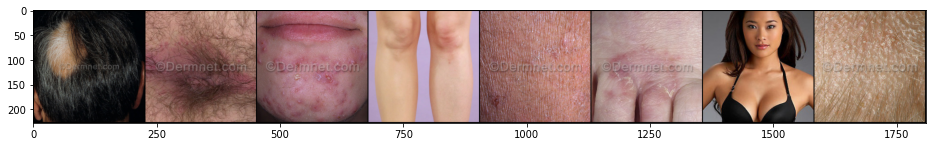

GroundTruth     Predicted      
Alopecia        Alopecia       
Tinea           Tinea          
Acne            Tinea          
Normal Skin     Normal Skin    
Tinea           Tinea          
Tinea           Tinea          
Normal Skin     Tinea          
Tinea           Tinea          


In [13]:
loader_test = load_dataset(path='Data/Skin/test', batch_size=n_batch_test, num_workers=0)
data_iter_test = iter(loader_test)
images, labels = data_iter_test.next()

# Custom Show images
plt.figure(figsize=(16,9))
imshow(torchvision.utils.make_grid(images))

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print("{0:<15} {1:<15}".format('GroundTruth', 'Predicted'))
for j in range(n_batch_test):
    print("{0:<15} {1:<15}".format(classes[labels[j]], classes[predicted[j]]))